# Empirical Asset Pricing with Machine Learning


In this enhanced portfolio analysis, we extend beyond the traditional CAPM approach by implementing various machine learning (ML) models. This analysis will allow us to capture complex relationships in financial data, handle additional features, and assess model performance through robust evaluation techniques.

---

## Key Steps in Machine Learning-Enhanced Portfolio Analysis

### 1. Multiple ML Models
   To compare with the CAPM's linear framework, we implement a range of machine learning models that include both linear and non-linear techniques.
   
   **Models Implemented**:
   - **Linear Models**: Ordinary Least Squares (OLS for CAPM), LASSO, Ridge, ElasticNet.
   - **Tree-Based Models**: Random Forest, XGBoost.
   - **Support Vector Regression (SVR)**: Adds flexibility for non-linear relationships.

   *Purpose*: Using a variety of ML models allows us to explore linear and non-linear relationships and identify the best-performing approach for asset returns prediction.

### 2. Enhanced Features
   We expand the feature set to capture a more comprehensive view of the market, beyond CAPM’s single-factor model. Additional features provide better context and predictive power.
   
   **Features Added**:
   - **Multiple Return Horizons**: Includes returns over different periods (1-day, 5-day, 21-day).
   - **Volume Indicators**: Incorporates volume metrics to gauge trading activity and liquidity.
   - **Rolling Volatility and Beta**: Measures of risk and sensitivity over time.
   - **Market-Relative Metrics**: Adds features comparing stock performance against the overall market.

   *Purpose*: These features help to capture more granular aspects of asset dynamics, addressing CAPM's limitations and accounting for time-varying relationships.

### 3. Robust Evaluation
   A rigorous evaluation strategy ensures the reliability of model performance, especially in the context of time series data.
   
   **Evaluation Methods**:
   - **Time Series Cross-Validation**: Uses rolling or expanding windows to simulate real-world forecasting and avoid look-ahead bias.
   - **Performance Metrics**: Evaluates models with multiple metrics such as R², Mean Squared Error (MSE), and Mean Absolute Error (MAE).
   - **Feature Importance Analysis**: Examines the relative importance of each feature, particularly for tree-based models.

   *Purpose*: This approach allows us to compare models consistently, understand each model's accuracy, and assess the impact of various features on predictions.

### 4. Visualizations
   Visualizations help interpret the performance and insights from each model, making it easier to understand the contributions of different features and compare model effectiveness.
   
   **Key Plots**:
   - **Model Performance Comparison**: Bar or line plots comparing R², MSE, and MAE across models.
   - **Feature Importance Plots**: Visualizations (e.g., bar plots) for feature importance, particularly for tree-based models.
   - **Cross-Validation Results**: Shows variations in model performance over different cross-validation folds to highlight robustness.

   *Purpose*: These visuals provide insights into which models perform best, which features are most impactful, and the consistency of predictions across time.

---

## Key Improvements Over Traditional CAPM

- **Non-Linear Relationships**: Machine learning models can capture complex relationships that CAPM’s linear approach misses.
- **Enhanced Feature Set**: By including multiple time horizons, volatility, volume, and market-relative metrics, we gain a more comprehensive view of asset behavior.
- **Handling of Time-Varying Relationships**: Rolling features and time series cross-validation allow for better adaptability to changing market conditions.
- **Feature Importance Insights**: Tree-based models and feature importance analysis highlight which factors drive asset returns, adding interpretability to the model outputs.

---

This machine learning approach builds on traditional CAPM by incorporating a broader range of features, allowing for non-linear modeling, and using rigorous validation to ensure reliable predictions.


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

## ## Set up necessary functions

In [3]:
class MLPortfolioAnalyzer:
    def __init__(self, tickers, start_date, end_date, market_ticker='^GSPC'):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.market_ticker = market_ticker
        self.stock_data = None
        self.market_data = None
        self.returns_data = None
        self.feature_data = None
        self.models = {}
        self.model_predictions = {}
        self.model_metrics = {}
        
    def download_data(self):
        """
        Download and prepare data including additional features
        """
        print("Downloading data...")
        
        # Download stock data
        self.stock_data = pd.DataFrame()
        for ticker in self.tickers:
            try:
                stock = yf.download(ticker, self.start_date, self.end_date)
                self.stock_data[f'{ticker}_Close'] = stock['Adj Close']
                self.stock_data[f'{ticker}_Volume'] = stock['Volume']
                print(f"Downloaded data for {ticker}")
            except Exception as e:
                print(f"Error downloading {ticker}: {e}")
        
        # Download market data
        try:
            market = yf.download(self.market_ticker, self.start_date, self.end_date)
            self.market_data = market['Adj Close']
            print(f"Downloaded market data ({self.market_ticker})")
        except Exception as e:
            print(f"Error downloading market data: {e}")
            
        self.prepare_features()
        
    def prepare_features(self):
        """
        Prepare features for machine learning models
        """
        # Calculate returns
        returns_dict = {}
        for ticker in self.tickers:
            price_col = f'{ticker}_Close'
            returns_dict[ticker] = self.stock_data[price_col].pct_change()
            
        # Calculate market return
        market_return = self.market_data.pct_change()
        returns_dict['Market'] = market_return
        
        self.returns_data = pd.DataFrame(returns_dict)
        
        # Create features DataFrame
        feature_data = pd.DataFrame(index=self.returns_data.index)
        
        for ticker in self.tickers:
            # Price-based features
            price_col = f'{ticker}_Close'
            volume_col = f'{ticker}_Volume'
            
            # Returns at different horizons
            feature_data[f'{ticker}_ret_1d'] = self.stock_data[price_col].pct_change()
            feature_data[f'{ticker}_ret_5d'] = self.stock_data[price_col].pct_change(5)
            feature_data[f'{ticker}_ret_21d'] = self.stock_data[price_col].pct_change(21)
            
            # Volume features
            feature_data[f'{ticker}_vol_ratio'] = (
                self.stock_data[volume_col] / 
                self.stock_data[volume_col].rolling(21).mean()
            )
            
            # Volatility
            feature_data[f'{ticker}_volatility'] = (
                feature_data[f'{ticker}_ret_1d'].rolling(21).std()
            )
            
            # Market relative features
            feature_data[f'{ticker}_beta_21d'] = (
                feature_data[f'{ticker}_ret_1d']
                .rolling(21)
                .cov(market_return) / 
                market_return.rolling(21).var()
            )
            
        # Market features
        feature_data['market_ret_1d'] = market_return
        feature_data['market_ret_5d'] = self.market_data.pct_change(5)
        feature_data['market_ret_21d'] = self.market_data.pct_change(21)
        feature_data['market_volatility'] = market_return.rolling(21).std()
        
        self.feature_data = feature_data.dropna()
        
    def prepare_ml_data(self, ticker, prediction_horizon=21):
        """
        Prepare data for ML models for a specific stock
        """
        # Prepare target variable (future returns)
        y = self.returns_data[ticker].shift(-prediction_horizon)
        
        # Remove target ticker's future information from features
        X = self.feature_data.copy()
        future_cols = [col for col in X.columns if ticker in col]
        X = X.drop(future_cols, axis=1)
        
        # Remove NaN values
        valid_idx = y.notna()
        X = X[valid_idx]
        y = y[valid_idx]
        
        return X, y
        
    def train_models(self, ticker, prediction_horizon=21):
        """
        Train multiple ML models for comparison
        """
        X, y = self.prepare_ml_data(ticker, prediction_horizon)
        
        # Prepare cross-validation
        tscv = TimeSeriesSplit(n_splits=5)
        
        # Initialize models
        models = {
            'OLS': LinearRegression(),
            'LASSO': Lasso(alpha=0.01),
            'Ridge': Ridge(alpha=0.01),
            'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5),
            'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5),
            'SVR': SVR(kernel='rbf', C=1.0),
            'XGBoost': xgb.XGBRegressor(max_depth=5, n_estimators=100)
        }
        
        # Train and evaluate models
        for name, model in models.items():
            cv_scores = []
            cv_predictions = []
            
            for train_idx, test_idx in tscv.split(X):
                # Split data
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                # Scale features
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                # Train model
                model.fit(X_train_scaled, y_train)
                
                # Make predictions
                y_pred = model.predict(X_test_scaled)
                cv_predictions.extend(y_pred)
                
                # Calculate metrics
                cv_scores.append({
                    'R2': r2_score(y_test, y_pred),
                    'MSE': mean_squared_error(y_test, y_pred),
                    'MAE': mean_absolute_error(y_test, y_pred)
                })
            
            # Store results
            self.models[f'{ticker}_{name}'] = model
            self.model_predictions[f'{ticker}_{name}'] = cv_predictions
            self.model_metrics[f'{ticker}_{name}'] = pd.DataFrame(cv_scores)
            
    def plot_model_comparison(self, ticker):
        """
        Plot comparison of model performances
        """
        # Prepare metrics for plotting
        metrics_df = pd.DataFrame()
        
        for model_name in ['OLS', 'LASSO', 'Ridge', 'ElasticNet', 
                          'RandomForest', 'SVR', 'XGBoost']:
            key = f'{ticker}_{model_name}'
            if key in self.model_metrics:
                metrics = self.model_metrics[key].mean()
                metrics['Model'] = model_name
                metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])])
        
        # Create figure with multiple subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        
        # Plot R2 scores
        sns.barplot(data=metrics_df, x='Model', y='R2', ax=axes[0])
        axes[0].set_title(f'{ticker} - R² Score Comparison')
        axes[0].tick_params(axis='x', rotation=45)
        
        # Plot MSE
        sns.barplot(data=metrics_df, x='Model', y='MSE', ax=axes[1])
        axes[1].set_title(f'{ticker} - MSE Comparison')
        axes[1].tick_params(axis='x', rotation=45)
        
        # Plot MAE
        sns.barplot(data=metrics_df, x='Model', y='MAE', ax=axes[2])
        axes[2].set_title(f'{ticker} - MAE Comparison')
        axes[2].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        return fig
    
    def plot_feature_importance(self, ticker):
        """
        Plot feature importance for tree-based models
        """
        rf_key = f'{ticker}_RandomForest'
        xgb_key = f'{ticker}_XGBoost'
        
        if rf_key in self.models and xgb_key in self.models:
            X, _ = self.prepare_ml_data(ticker)
            feature_names = X.columns
            
            # Create figure
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
            
            # Random Forest importance
            rf_importance = pd.Series(
                self.models[rf_key].feature_importances_,
                index=feature_names
            ).sort_values(ascending=True)
            
            rf_importance.plot(kind='barh', ax=ax1)
            ax1.set_title('Random Forest Feature Importance')
            
            # XGBoost importance
            xgb_importance = pd.Series(
                self.models[xgb_key].feature_importances_,
                index=feature_names
            ).sort_values(ascending=True)
            
            xgb_importance.plot(kind='barh', ax=ax2)
            ax2.set_title('XGBoost Feature Importance')
            
            plt.tight_layout()
            return fig

## Perform analysis

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for AAPL
Downloaded data for MSFT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for GOOGL
Downloaded data for AMZN


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_612/3664912474.py:112: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[valid_idx]


Downloaded data for META
Downloaded market data (^GSPC)

Training models for AAPL...


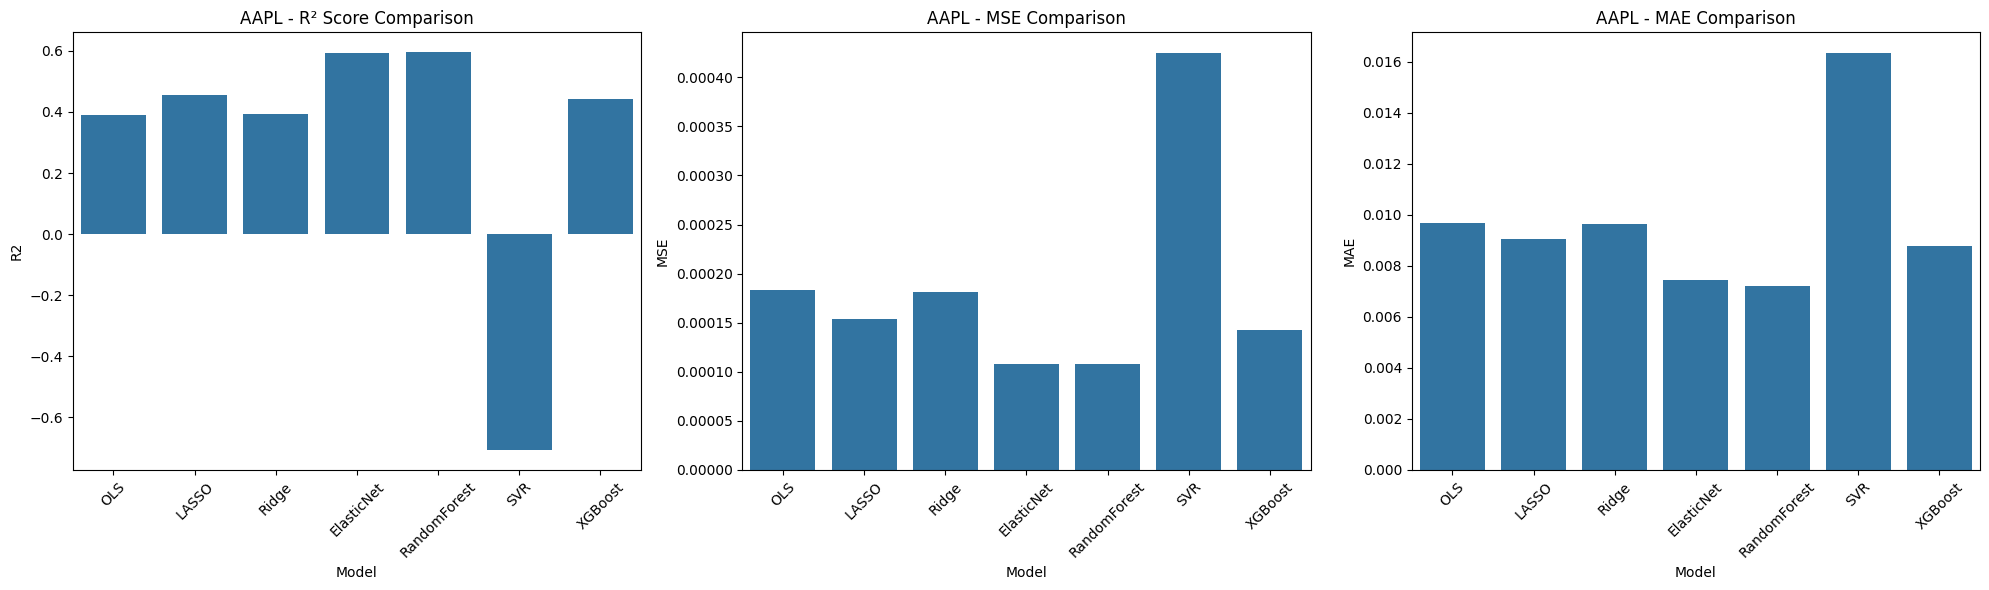

/tmp/ipykernel_612/3664912474.py:112: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[valid_idx]


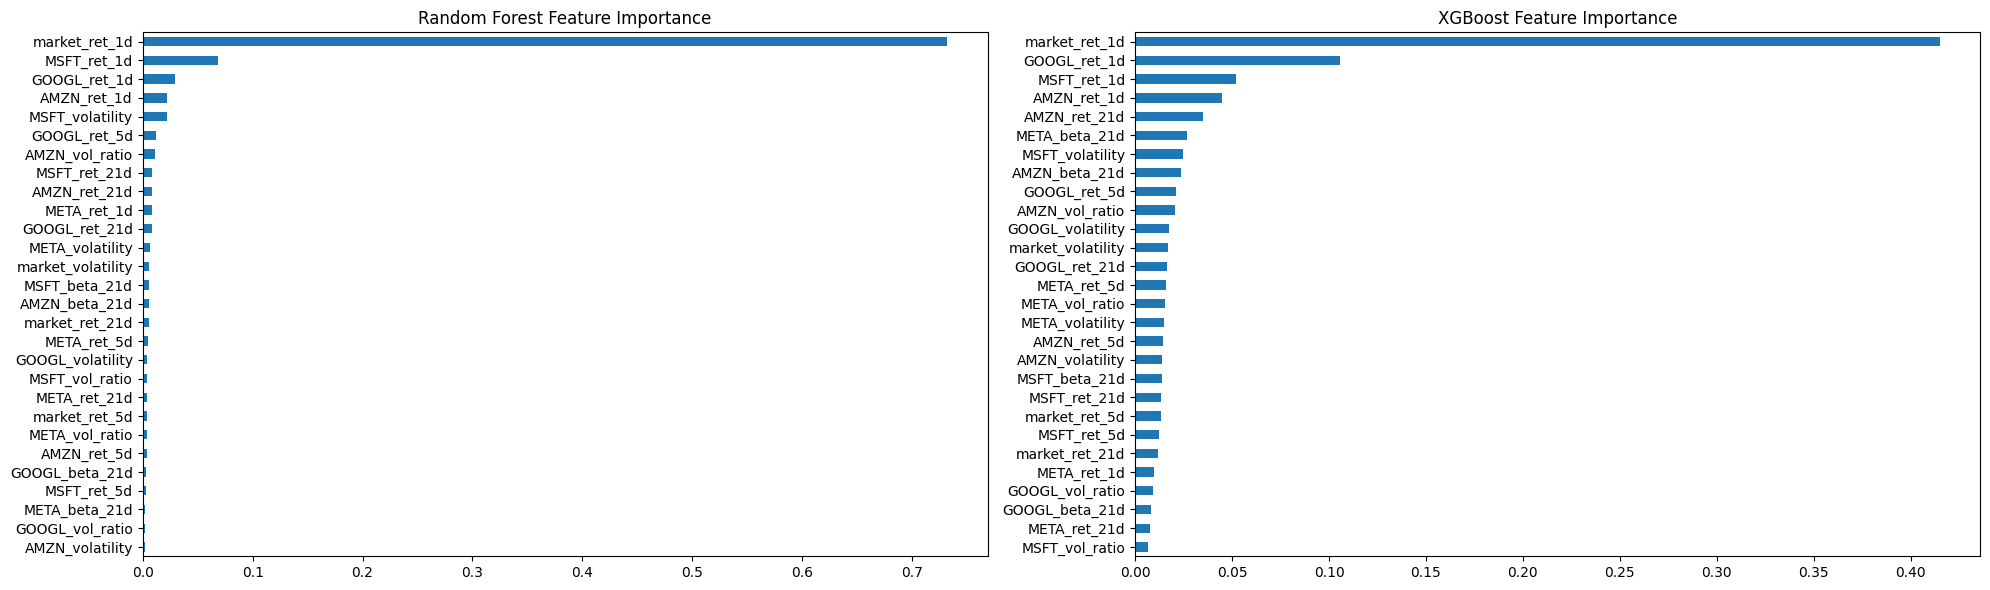


Training models for MSFT...


/tmp/ipykernel_612/3664912474.py:112: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[valid_idx]


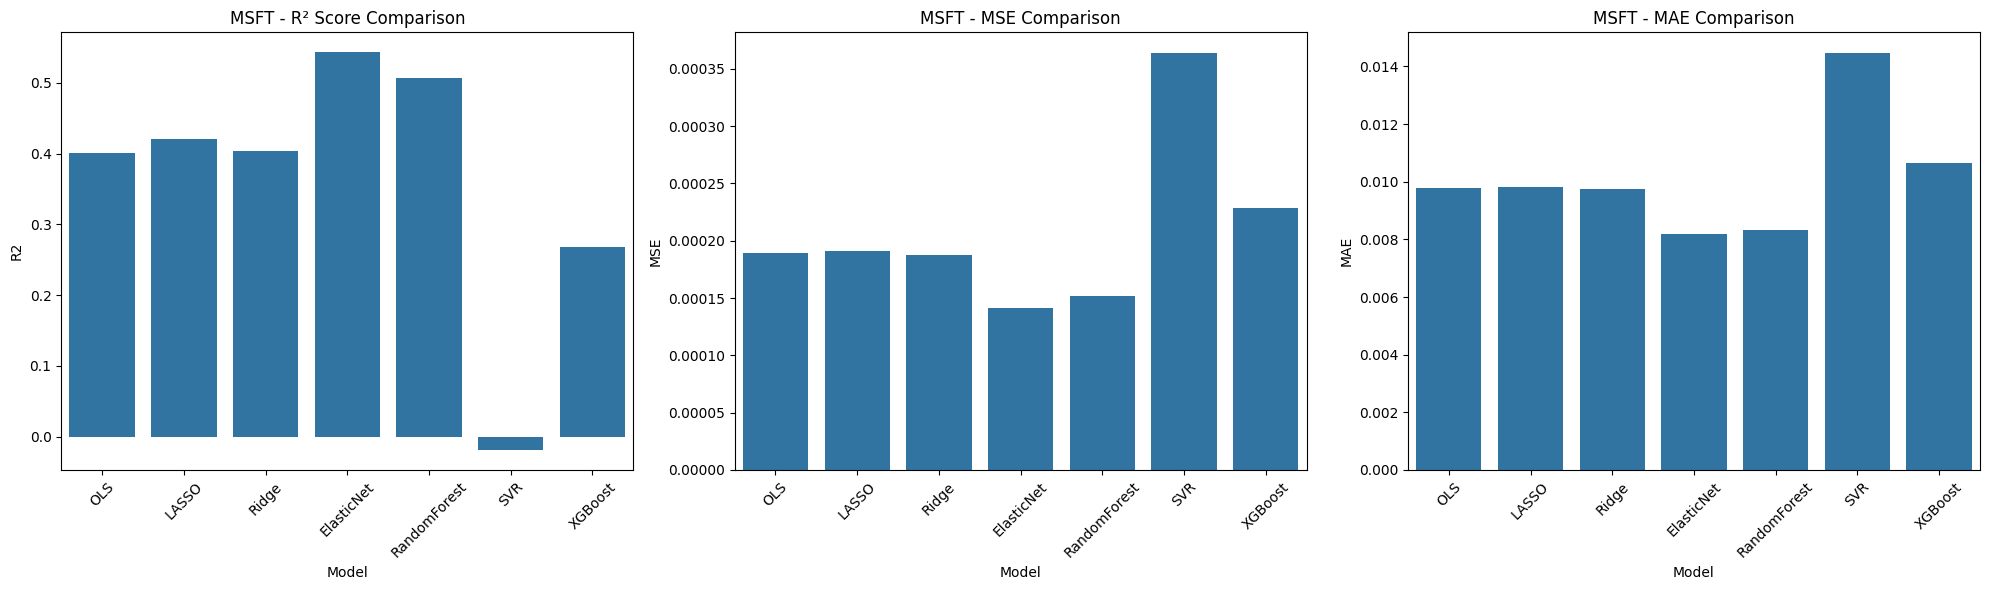

/tmp/ipykernel_612/3664912474.py:112: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[valid_idx]


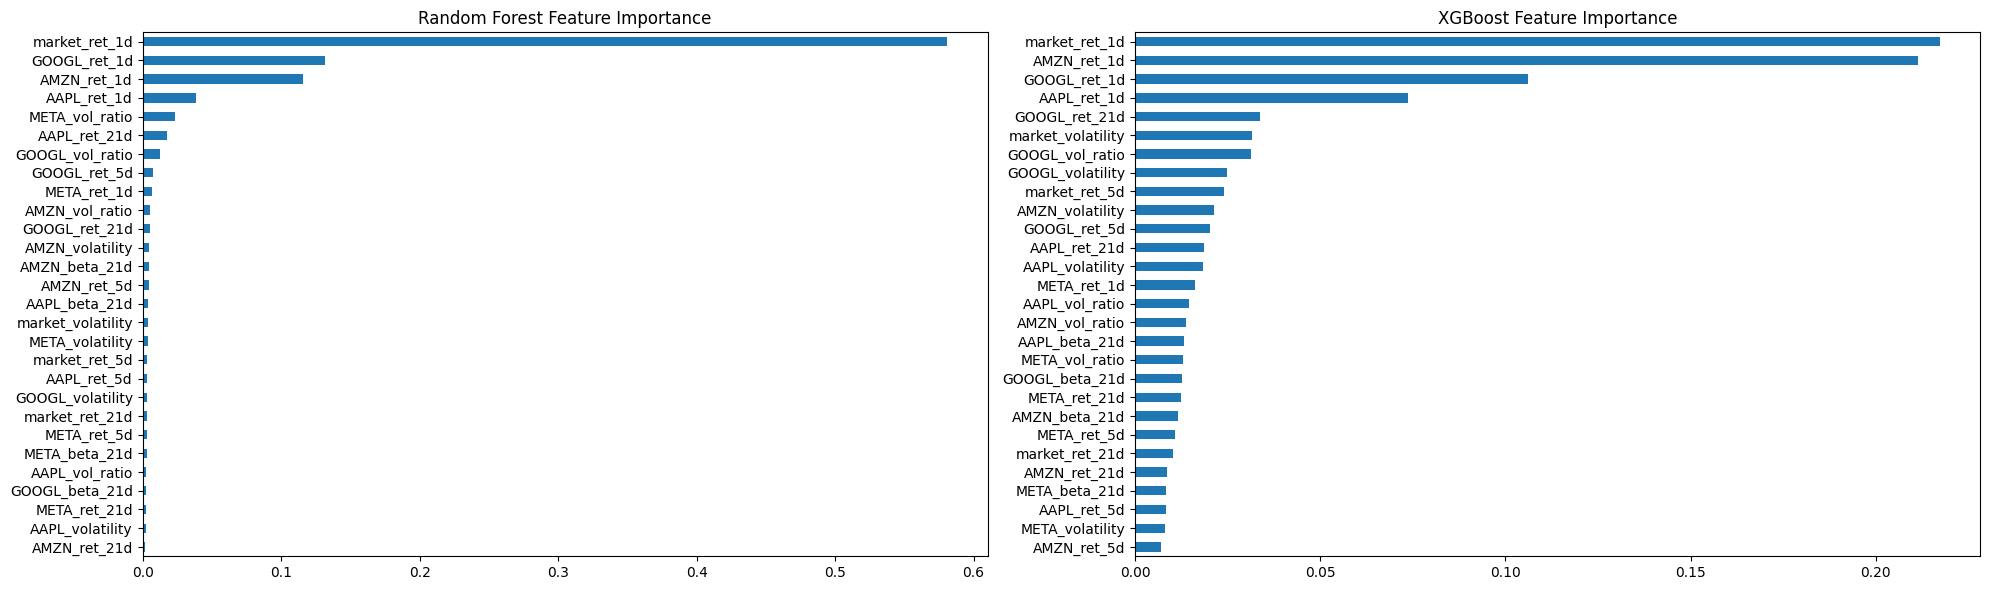


Training models for GOOGL...


/tmp/ipykernel_612/3664912474.py:112: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[valid_idx]


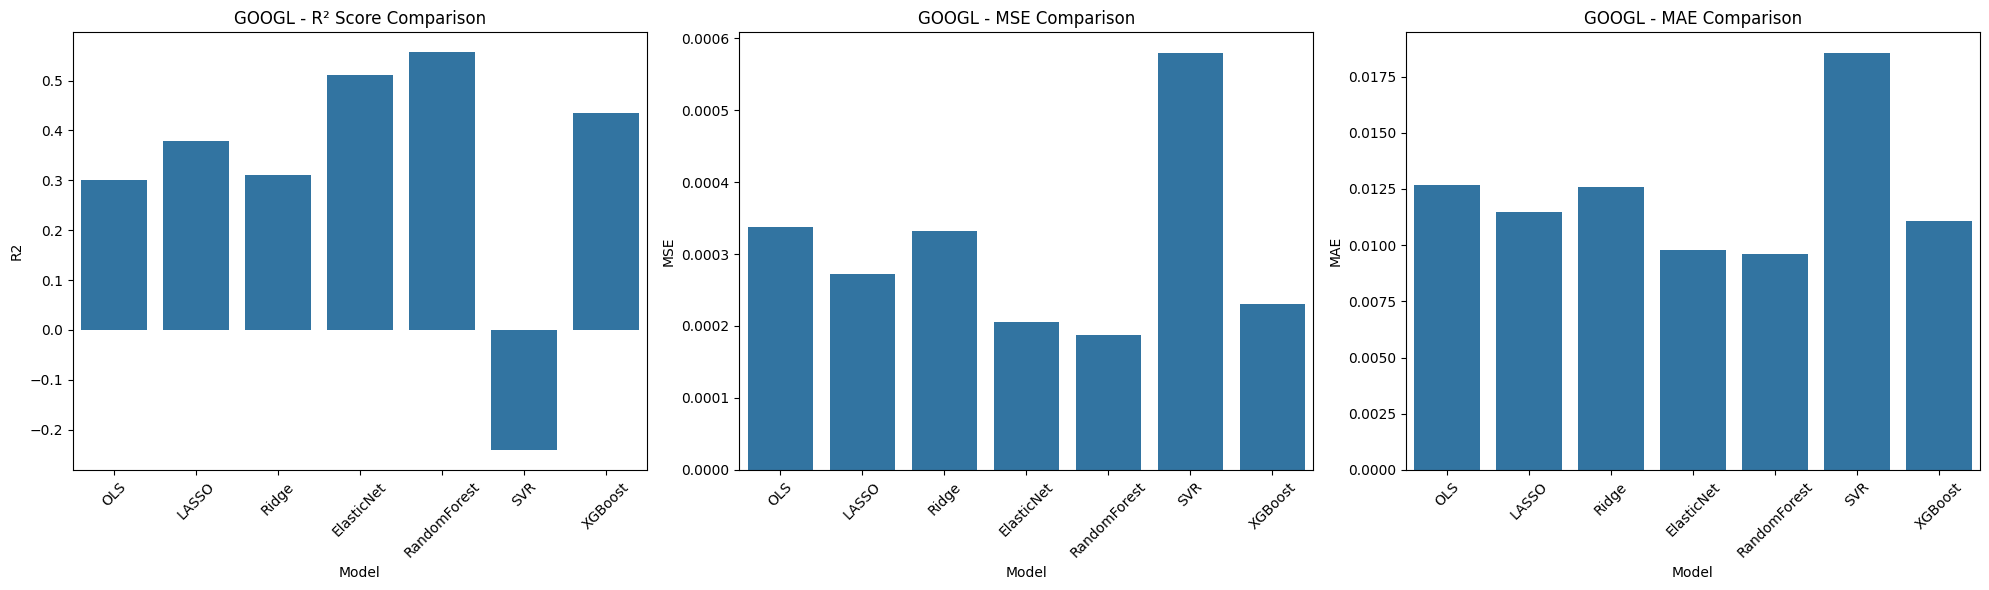

/tmp/ipykernel_612/3664912474.py:112: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[valid_idx]


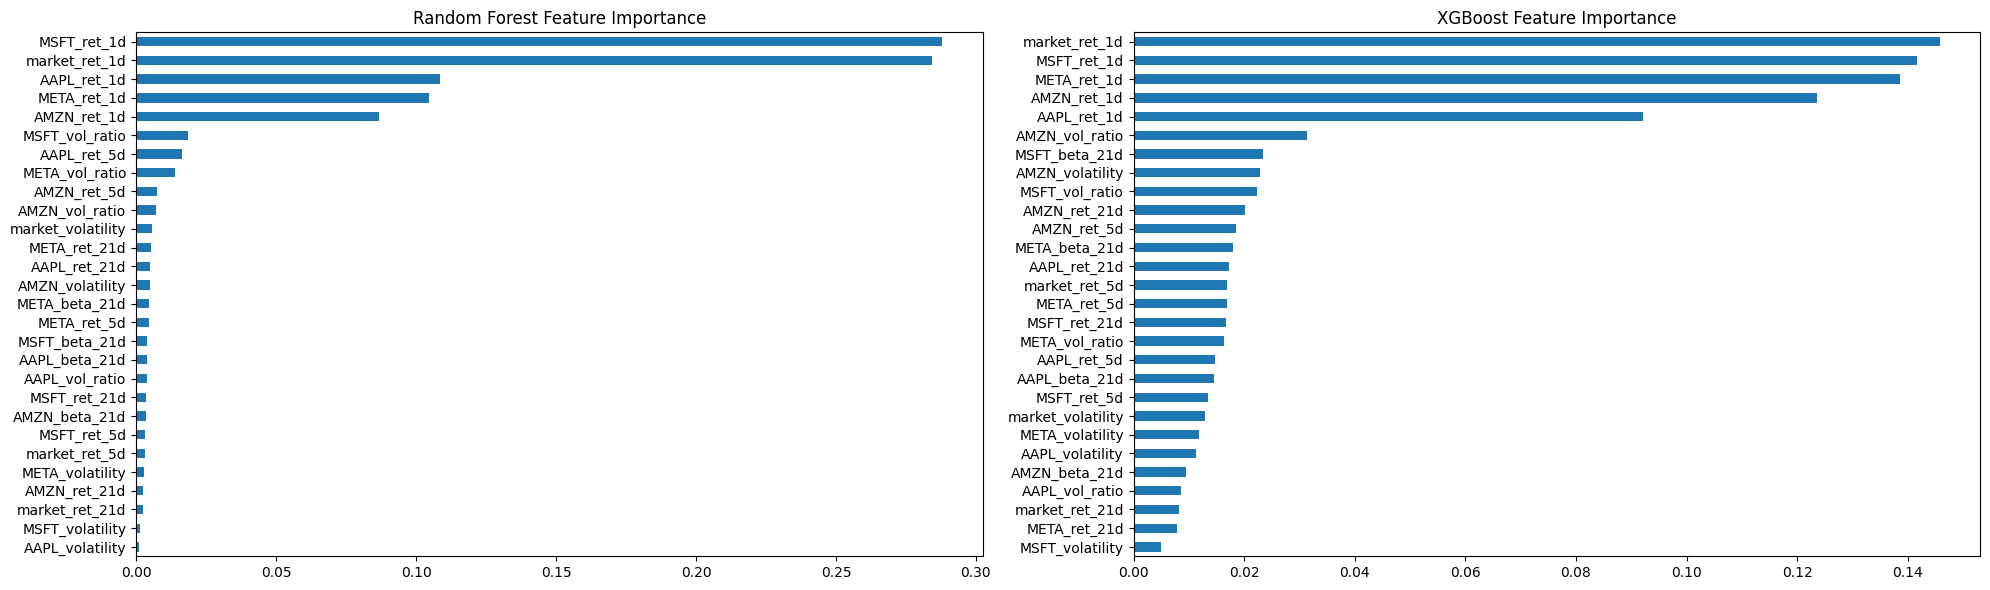


Training models for AMZN...


/tmp/ipykernel_612/3664912474.py:112: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[valid_idx]


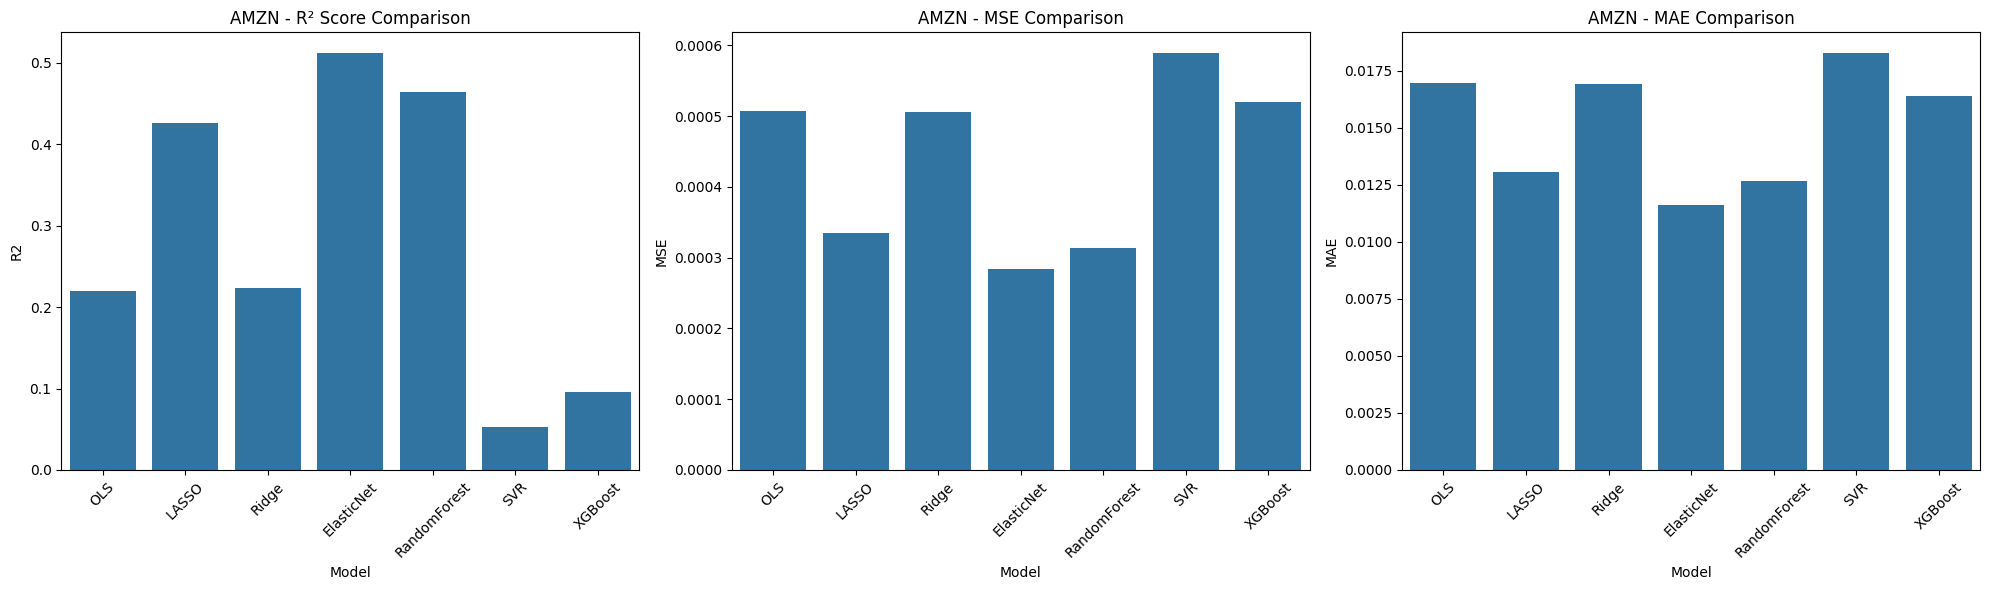

/tmp/ipykernel_612/3664912474.py:112: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[valid_idx]


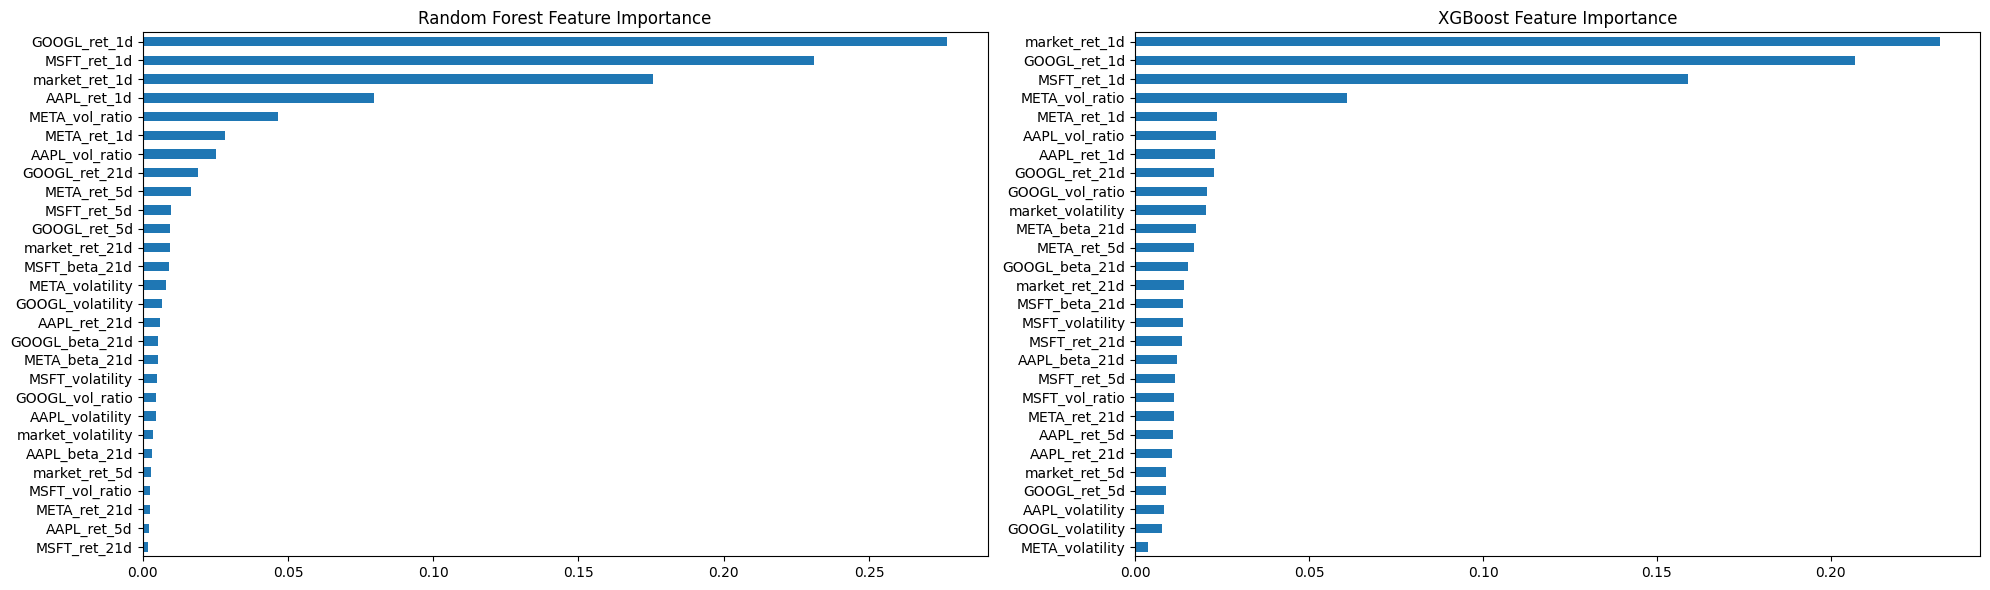


Training models for META...


/tmp/ipykernel_612/3664912474.py:112: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[valid_idx]


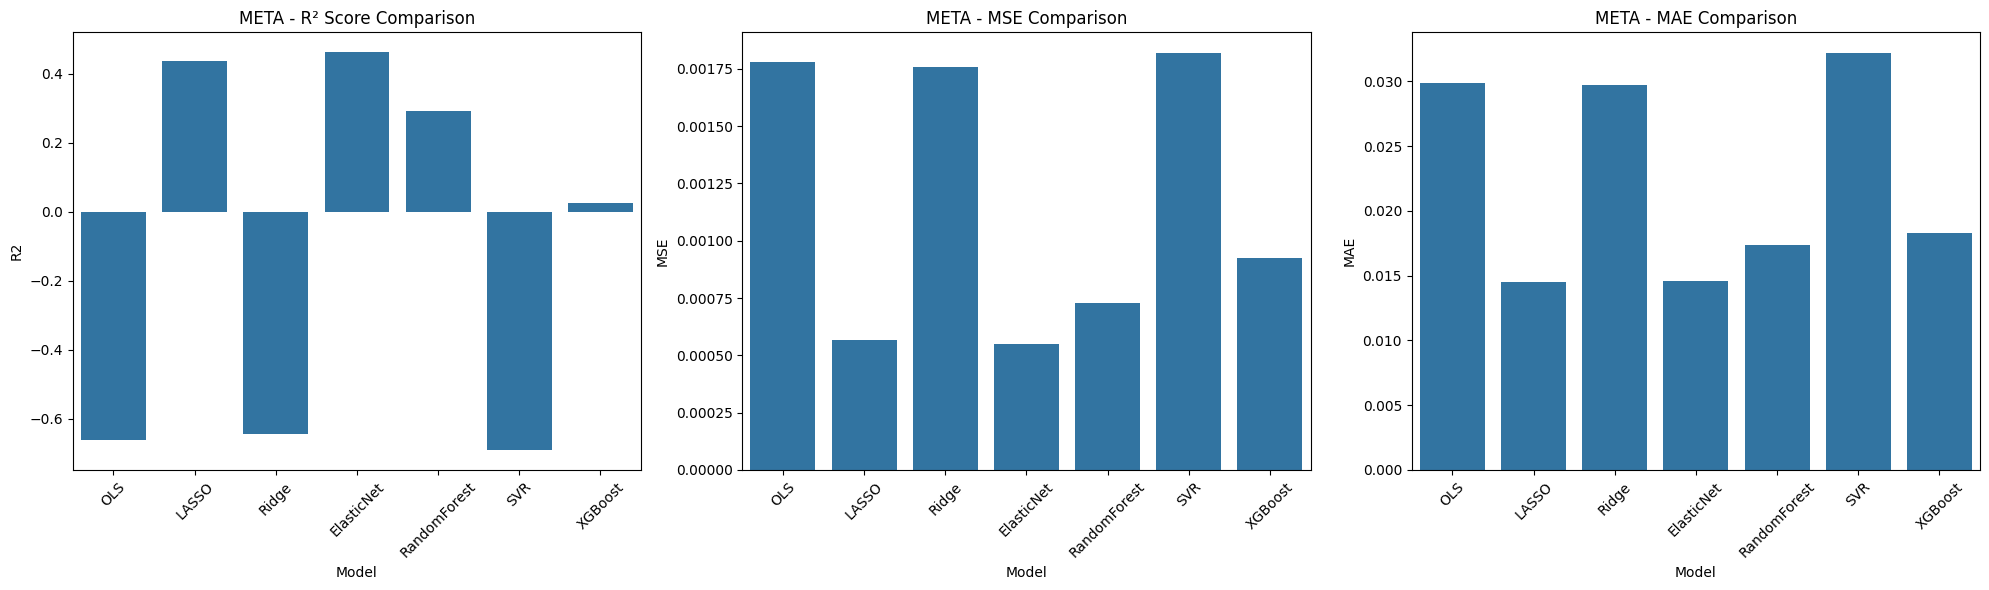

/tmp/ipykernel_612/3664912474.py:112: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[valid_idx]


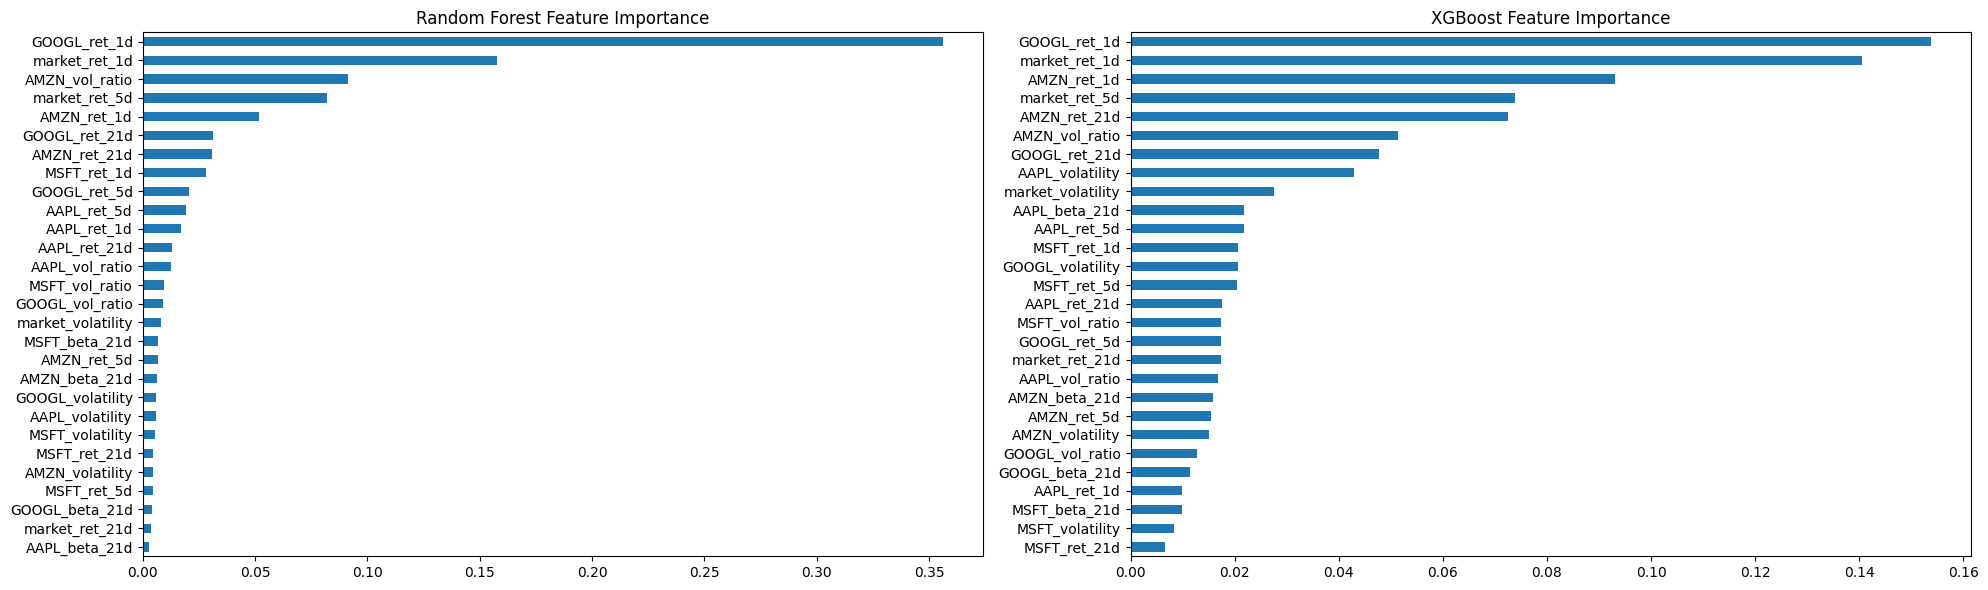

In [5]:
# Define parameters
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']  # Reduced list for example
start_date = '2022-01-01'
end_date = '2024-01-01'

# Create analyzer instance
analyzer = MLPortfolioAnalyzer(tickers, start_date, end_date)

# Download and prepare data
analyzer.download_data()

# Train models for each stock
for ticker in tickers:
    print(f"\nTraining models for {ticker}...")
    analyzer.train_models(ticker)
    
    # Plot comparisons
    analyzer.plot_model_comparison(ticker)
    plt.show()
    
    # Plot feature importance
    analyzer.plot_feature_importance(ticker)
    plt.show()
